In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [116]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

In [117]:
#2-layer encoder-decoder with relu activation
class Encoder(nn.Module):
    def __init__(self, interm_size=32, latent_size=32, act=torch.relu):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, interm_size)
        self.fc2 = nn.Linear(interm_size, latent_size)
        self.act = act
    
    def forward(self, x):
        interm = self.act(self.fc1(x))
        latent = self.act(self.fc2(interm))
        return latent
    
class Decoder(nn.Module):
    def __init__(self, interm_size=32, latent_size=32, act=torch.relu):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, interm_size)
        self.fc2 = nn.Linear(interm_size, 28*28)
        self.act = act
    
    def forward(self, x):
        interm = self.act( self.fc1(x) )
        output = torch.tanh( self.fc2(interm) ) 
        return output

In [118]:
class Net(nn.Module):
    def __init__(self, interm_size=32, latent_size=32, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.E = Encoder(interm_size, latent_size)
        self.D = Decoder(interm_size, latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [119]:
models = {'16-16': Net(16,16), '32-32': Net(32,32), '64-64': Net(64,64)}
models.update({'64-16': Net(64,16), '64-8': Net(64,8), '64-4': Net(64,4)})
#models.update({'32-16': Net(32,16), '32-8': Net(32,8), '32-4': Net(32,4)})
#models.update({'16-8': Net(16,8), '16-4': Net(16,4)})
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [120]:
def add_noise(x, mode='crop', elementwise=False, skip_one_half = False):
    
    gaus_mean = 0.0
    gaus_sigma = 0.8
    
    if skip_one_half and np.random.randint(2):
        return x
    x = x.clone()
    if elementwise:
        for i in range(x.shape[0]):
            if mode == 'crop':
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2)*2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
            elif mode == 'mirror_full_image':
                x[i] = torch.flip(x[i], [2])
            elif mode == 'gaussian':
                distortions = torch.empty(x[i].size()).normal_(mean=gaus_mean,std=gaus_sigma)
                x[i] += distortions
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror_full_image':
            #Negative step slicing not supported for pytorch tensors (?)
            x = torch.flip(x, [3])
        elif mode == 'gaussian':
            distortions = torch.empty(x.size()).normal_(mean=gaus_mean,std=gaus_sigma)
            x += distortions
        
    return x

In [121]:
def train(epoch, models, noise_mode='gaussian', log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noisy_data = add_noise(data, mode = noise_mode)
        for model in models.values():
            model.optim.zero_grad()
            output = model(noisy_data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [122]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, noise_mode='gaussian', log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noisy_data = add_noise(data, mode = noise_mode)
            output = {k: m(noisy_data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [123]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

for model in models.values():
    model.apply(weight_reset)

In [124]:
noise_mode = 'gaussian'
for epoch in range(1, 20):
    for model in models.values():
        model.train()
    train(epoch, models, noise_mode, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, noise_mode, test_log)

Train Epoch: 1 [00000/60000] 16-16: 0.963241 32-32: 0.939730 64-64: 0.932475 64-16: 0.943325 64-8: 0.947309 64-4: 0.951669
Train Epoch: 1 [30000/60000] 16-16: 0.838890 32-32: 0.530284 64-64: 0.316641 64-16: 0.353150 64-8: 0.407101 64-4: 0.426293
Train Epoch: 1 [60000/60000] 16-16: 0.590179 32-32: 0.291022 64-64: 0.245212 64-16: 0.260722 64-8: 0.261400 64-4: 0.264132
Test set:
16-16: loss: 0.5892
32-32: loss: 0.2912
64-64: loss: 0.2462
64-16: loss: 0.2615
64-8: loss: 0.2630
64-4: loss: 0.2655

Train Epoch: 2 [00000/60000] 16-16: 0.581525 32-32: 0.281117 64-64: 0.237247 64-16: 0.251777 64-8: 0.252764 64-4: 0.255515
Train Epoch: 2 [30000/60000] 16-16: 0.402111 32-32: 0.263466 64-64: 0.208690 64-16: 0.238794 64-8: 0.240240 64-4: 0.248362
Train Epoch: 2 [60000/60000] 16-16: 0.321802 32-32: 0.255131 64-64: 0.185213 64-16: 0.216992 64-8: 0.230424 64-4: 0.238879
Test set:
16-16: loss: 0.3271
32-32: loss: 0.2598
64-64: loss: 0.1901
64-16: loss: 0.2224
64-8: loss: 0.2390
64-4: loss: 0.2457

Trai

KeyboardInterrupt: 

Default config, 20 epochs

In [125]:
data, labels = next(iter(test_loader))
noisy_data = add_noise(data, mode='gaussian')
output = models['64-64'](noisy_data[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

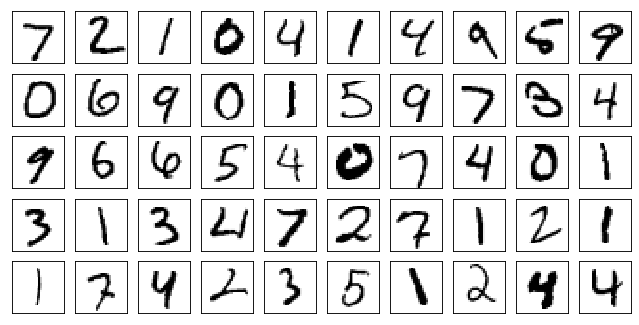

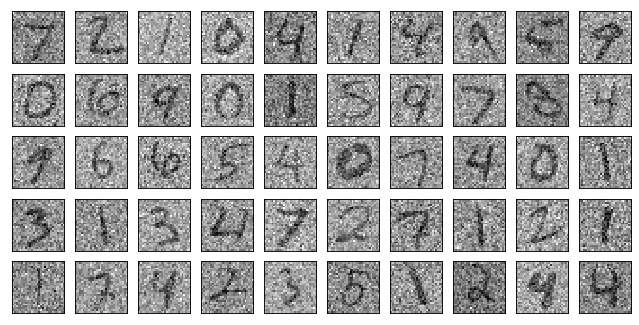

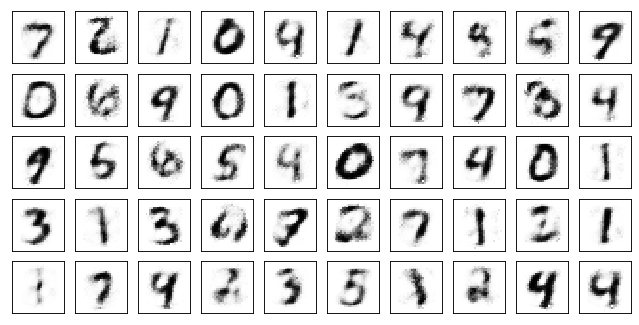

In [126]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noisy_data[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

Plotting hidden layer activations class-wise

In [183]:
train_loader, test_loader = mnist(batch_size=8000, valid=0, transform=mnist_transform)

In [184]:
data, labels = next(iter(train_loader))
noisy_data = add_noise(data, mode='gaussian')

In [185]:
encoder_trained = list(models['64-64'].children())[0]

In [186]:
subset = noisy_data.view(-1, 28*28)

In [187]:
encoder_output = encoder_trained(subset).detach().numpy()

In [188]:
encoder_output.shape

(8000, 64)

In [189]:
#reshape 64 activations to 8 by 8 matrix
output_reshaped = encoder_output.reshape((8000, 8, 8))

In [190]:
#get list of all activations class-wise
classes_outputs = {}
for idx, output in enumerate(output_reshaped):
    img_class = int(labels[idx])
    val = classes_outputs.get(img_class,[])
    val.append(output)
    classes_outputs[img_class] = val

In [199]:
#average activations per class over all input instances of this class
classes_averaged_outputs = {class_value: np.average(output_list,axis=0) 
                            for class_value, output_list in classes_outputs.items()}

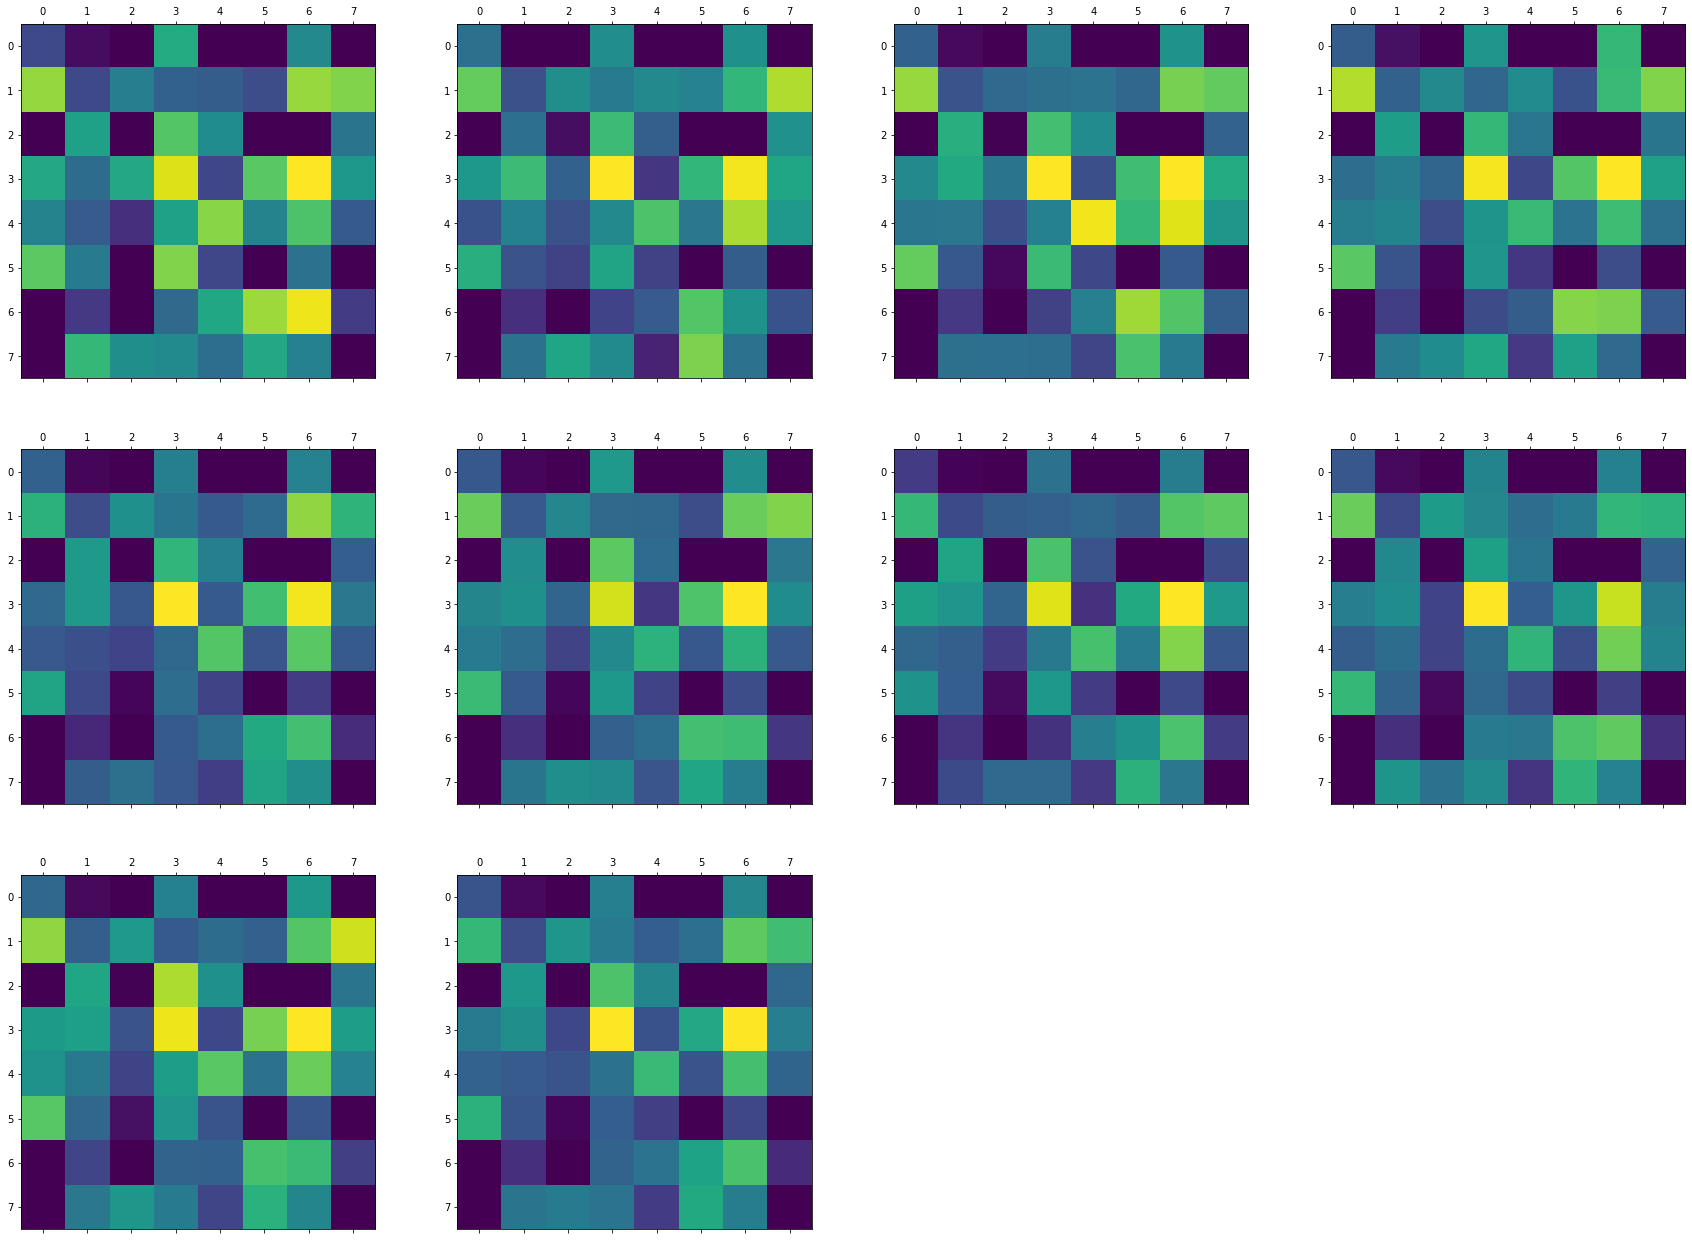

In [200]:
fig = plt.figure(figsize=(30,30))
for img_class, averaged_outputs in classes_averaged_outputs.items():
    z = classes_averaged_outputs[img_class]
    ax = fig.add_subplot(4, 4, img_class+1)
    ax.matshow(z,interpolation='none')
plt.show()

Cross-check: give averaged activations class-wise to the decoder, 
see if the (averaged) written numbers are reconstructed

In [201]:
decoder_trained = list(models['64-64'].children())[1]

In [202]:
input_for_decoder = [torch.tensor(classes_averaged_outputs[i].reshape(64)) 
                     for i in classes_averaged_outputs]

In [203]:
images_from_averaged_activations = [decoder_trained(x).reshape(28,28).detach().numpy() 
                                    for x in input_for_decoder]

<Figure size 2160x2160 with 0 Axes>

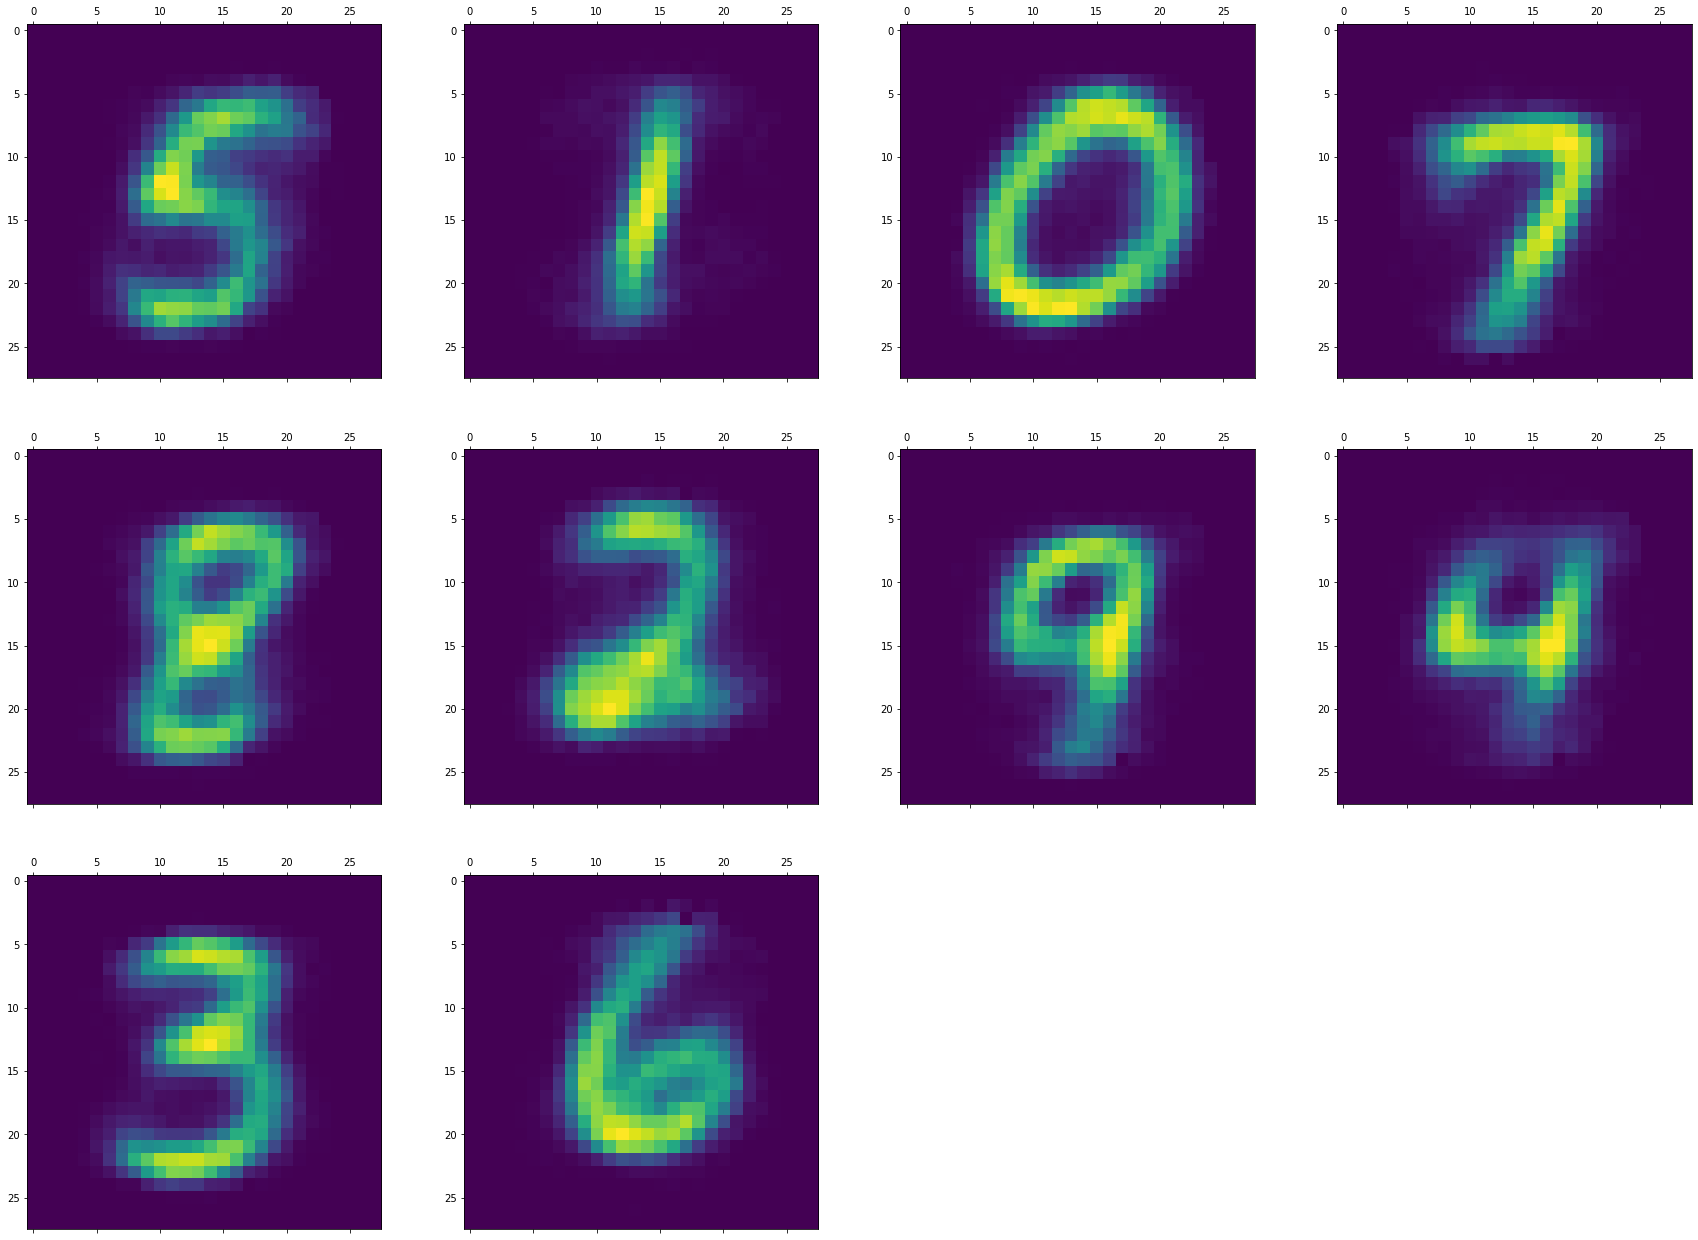

In [204]:
fig = plt.figure(figsize=(30,30))
fig = plt.figure(figsize=(30,30))
for idx, img in enumerate(images_from_averaged_activations):
    ax = fig.add_subplot(4, 4, idx+1)
    ax.matshow(img,interpolation='none')
plt.show()